In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST data
(x_train, _), (_, _) = mnist.load_data()

# Preprocess data
x_train = x_train.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28 * 28))

# Define RBM class
class RBM:
    def __init__(self, visible_size, hidden_size):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.W = tf.Variable(tf.random.normal([visible_size, hidden_size], mean=0.0, stddev=0.01))
        self.bv = tf.Variable(tf.zeros([visible_size]))
        self.bh = tf.Variable(tf.zeros([hidden_size]))

    def sample_h_given_v(self, v):
        prob_h_given_v = tf.nn.sigmoid(tf.matmul(np.reshape(v,(1,v.shape[0])), self.W) + self.bh)
        return tf.nn.relu(tf.sign(prob_h_given_v - tf.random.uniform(tf.shape(prob_h_given_v))))

    def sample_v_given_h(self, h):
        prob_v_given_h = tf.nn.sigmoid(tf.matmul(self.W,tf.transpose(h)) + self.bv)
        return tf.nn.relu(tf.sign(prob_v_given_h - tf.random.uniform(tf.shape(prob_v_given_h))))

    def train(self, X, learning_rate=0.1, k=1):
        for i in range(len(X)):
            v0 = X[i]
            vk = v0

            ph0 = tf.nn.sigmoid(tf.matmul([v0], self.W) + self.bh)
            for _ in range(k):
                hk = self.sample_h_given_v(vk)
                vk = self.sample_v_given_h(hk)

            phk = tf.nn.sigmoid(tf.matmul([vk], self.W) + self.bh)

# there are still some transposition problems here
            self.W.assign_add(learning_rate * (tf.matmul(tf.transpose(v0), ph0) - tf.matmul(tf.transpose(vk), phk)))
            self.bv.assign_add(learning_rate * tf.reduce_sum(v0 - vk, axis=0))
            self.bh.assign_add(learning_rate * tf.reduce_sum(ph0 - phk, axis=0))

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Initialize RBM
visible_size = 28 * 28
hidden_size = 128
rbm = RBM(visible_size, hidden_size)

# Training RBM
epochs = 10
batch_size = 64

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        rbm.train(batch)

# Generate artificial samples
num_samples = 10
generated_samples = []

for _ in range(num_samples):
    v0 = np.random.rand(visible_size)
    vk = v0

    for _ in range(1000):  # Gibbs sampling steps
        hk = rbm.sample_h_given_v(vk)
        vk = rbm.sample_v_given_h(hk)

    generated_samples.append(np.reshape(vk, (28, 28)))

# Display generated samples
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_samples[i], cmap='gray')
    plt.axis('off')

plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
print(len(x_train))

60000


## implementation stollen from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

In [3]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)


In [5]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()



In [7]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.01)
losses=[]

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -19.158178329467773
Training loss for 1 epoch: -14.19632339477539
Training loss for 2 epoch: -14.054471015930176
Training loss for 3 epoch: -13.414416313171387
Training loss for 4 epoch: -13.142909049987793
Training loss for 5 epoch: -12.65015697479248
Training loss for 6 epoch: -12.00126838684082
Training loss for 7 epoch: -11.506896018981934
Training loss for 8 epoch: -11.096857070922852
Training loss for 9 epoch: -10.614951133728027


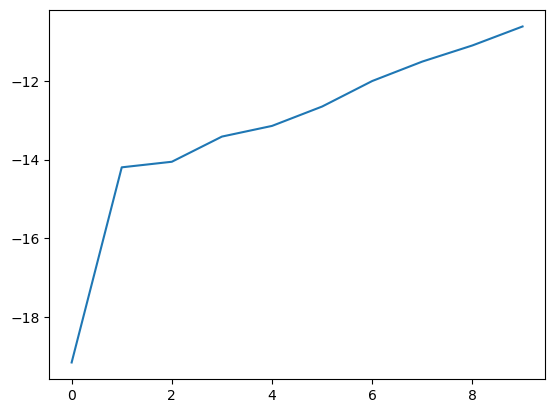

In [9]:
plt.plot(losses)

In [10]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)


In [ ]:
show_and_save("real",make_grid(v.view(100,1,28,28).data))


NameError: name 'show_and_save' is not defined

In [8]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))


NameError: name 'show_and_save' is not defined